# Tanaka function
---
Description:

- Optimization (min, max)
- Multi-objective (2)
- Constraints (2)
---

The equations are given by:

\begin{cases}
      f_{1}\left(\mathbf{x}\right) = x, \text{ needs to maximize} \\
      f_{2}\left(\mathbf{x}\right) = y, \text{ needs to minimize} \\
\end{cases}

subject to:

\begin{cases}
      C_{1}\left(\mathbf{x}\right) = x^{2} + y^{2} - 1 - 0.1\cos\left(16 \arctan(x/y) \right) \geq 0, \\
      C_{2}\left(\mathbf{x}\right) = \left(x - 0.5\right)^{2} + \left(y - 0.5\right)^{2} \leq 0.5 \\
\end{cases}

where:

\begin{cases}
      0\le x \le \pi, \\
      0\le y \le \pi. \\
\end{cases}

The constrained Pareto-optimal solutions lie on the boundary of the first constraint. Since the constraint function is periodic and the second constraint function must also be satisfied, not all solutions on the boundary of the first constraint are Pareto-optimal. 

## First we import python libraries and set up the directory

In [1]:
import os, sys
import numpy as np
from math import fsum, isclose
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.abspath('..')
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code.

In [45]:
from ppso.auxiliary.swarm import Swarm
from ppso.auxiliary.particle import Particle
from ppso.engines.standard_pso import StandardPSO

## Define the multi-objective function

In [60]:
# Multi-objective function.
def fun_Tanaka(z: np.typing.ArrayLike,
               apply_constraint: bool = True):
    
    # Set the penalty coefficient.
    rho = 50.0
    
    # Extract the values from the particle position.
    x, y = z
    
    # Avoid "division by zero" errors.
    if y == 0.0:
        y = 1.0e-8
    # _end_if_
    
    # Compute each objective function.
    f1, f2 = x, y

    # Check if we want the constraints to be applied.
    if apply_constraint:
        # Compute the constraints.
        C1 = min(0.0, x**2 + y**2 - 1.0 - 0.1*np.cos(16.0 * np.arctan(x/y)))**2
        C2 = max(0.0, (x - 0.5)**2 + (y - 0.5)**2 - 0.5)**2

        # Compute the final value. The negative sign is for the minimization.
        f_val = -fsum([0.5*f1, -0.5*f2, rho*(C1 + C2)])
    else:
        # Return both functions values.
        f_val = (f1, f2)
    # _end_if_

    # Condition for termination.
    solution_found = False
    
    # Return the solution tuple.
    return f_val, solution_found
# _end_def_

## Here we set the PSO parameters

- Set the number of dimensions 'D'
- Set the number of particles 'N'
- Setup the initial population
- Create the PSO object

In [61]:
# Random number generator.
rng = np.random.default_rng()

# Define the number of optimizing variables.
D = 2

# Define the number of particles.
N = 100

# Draw random samples for the initial points.
X_t0 = rng.uniform(0.0, np.pi, size=(N, D))

# Initial population.
swarm_t0 = Swarm([Particle(x) for x in X_t0])

# Create the StandardPSO object that will carry on the optimization.
test_PSO = StandardPSO(initial_swarm=swarm_t0, obj_func=fun_Tanaka,
                       x_min=0.0, x_max=np.pi)

## Optimization process

In [62]:
test_PSO.run(max_it = 500,
             options = {"w": 0.25, "c1": 2.05, "c2": 1.85, "fipso": True},
             reset_swarm = True,
             verbose = True)

Initial f_optimal = 0.3406
Iteration:     1 -> f_optimal = 0.0609
Iteration:    51 -> f_optimal = 0.4952
Iteration:   101 -> f_optimal = 0.4980
Iteration:   151 -> f_optimal = 0.4989
Iteration:   201 -> f_optimal = 0.4992
Iteration:   251 -> f_optimal = 0.4995
Iteration:   301 -> f_optimal = 0.4996
Iteration:   351 -> f_optimal = 0.4996
Iteration:   401 -> f_optimal = 0.4996
Iteration:   451 -> f_optimal = 0.4997
Final f_optimal = 0.4997
run: elapsed time = 1.532 seconds.


In [63]:
# Extract the optimal solution from the PSO.
optimal_solution = test_PSO.swarm.best_particle()

# Get the optimal value WITHOUT the constraint.
f_optimal, _ = fun_Tanaka(optimal_solution.position,
                          apply_constraint=False)

# Extract optimal f values.
f1_opt, f2_opt = f_optimal

# Display the (final) optimal values.
print(f"Optimum Found: {f_optimal}\n")

# Display each gene value separately.
for i, xi in enumerate(optimal_solution.position, start=1):
    print(f"x{i} = {xi:>10.6f}")
# _end_for_

Optimum Found: (0.038405412107349185, 1.0402950136145126)

x1 =   0.038405
x2 =   1.040295


### Compute the Pareto Frontier (solutions).

In [34]:
# Create a list that will hold points that satisfy both constraints.
points = []

# Generate grid sample on [0, pi].
for x in np.linspace(0.0, np.pi, 100):
    
    for y in np.linspace(0.0, np.pi, 100):
        
        # Avoid "division by zero" errors.
        if y == 0.0:
            y = 1.0e-8
        # _end_if_

        # Compute the constraints.
        C1 = x**2 + y**2 - 1.0 - 0.1*np.cos(16.0 * np.arctan(x/y)) >= 0.0
        C2 = (x - 0.5)**2 + (y - 0.5)**2 <= 0.5

        # If both constraints are satisfied.
        if C1 and C2:

            # Evaluate both functions.
            f1, f2 = x, y

            # Keep the point in the list.
            points.append((f1, f2))
        # _end_if_
    # _end_if_
# _end_for_

# Estimate the pareto front points.
pareto_points = pareto_front(points)

# Convert lists to numpy.
points = np.array(points)
pareto_points = np.array(pareto_points)

### Visualize the solution on the Pareto plot.

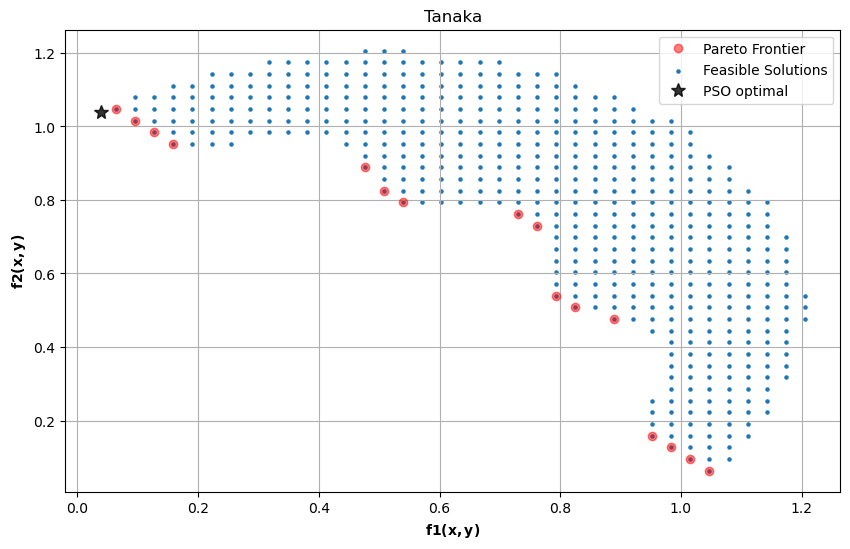

In [64]:
# Create a new figure.
plt.figure(figsize=(10, 6))

# Plot the Pareto front.
plt.plot(pareto_points[:, 0],
         pareto_points[:, 1],
         'ro', alpha=0.5, label="Pareto Frontier")

# Plot all the feasible solutions.
plt.scatter(x=points[:, 0],
            y=points[:, 1],
            s=5, marker='o', label="Feasible Solutions")

# Plot the optimal solution from the PSO.
plt.plot(f1_opt, f2_opt,
         'k*', markersize=10, alpha=0.8, label="PSO optimal")

# Tidy up the plot.
plt.title("Tanaka")
plt.xlabel(r"$\mathbf{f1(x,y)}$")
plt.ylabel(r"$\mathbf{f2(x,y)}$")
plt.legend()
plt.grid(True)

plt.savefig("Tanaka_optimal.pdf", format="pdf", dpi=300)

### End of file